In [1]:
# Imports
%matplotlib inline

# Import statements
import os # for directory operations
import numpy as np # for numerical/linear algebra methods
import pandas as pd # for data(frame) processing
import pdb # for debudding
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for cool plotting
import re # for regular expression
import nltk # natural language processing toolkit
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from langdetect import detect, detect_langs # for language detection
from tqdm.notebook import tqdm, trange
import time
import math
from collections import Counter
import spacy
import pickle
import ast
from collections import Counter

In [2]:
# GLOBAL VARIABLES
PLOT_DIMS = (11.7, 8.27)
TITLE_SIZE = 30
LABEL_SIZE = 25
TICK_SIZE=20

In [3]:
case_df = pd.read_csv('../data/bnc/bnc_rb_10p_testset_case_analysis_final_ws.csv', encoding="utf-8")

# Add length column for clean text
case_df['clean_length'] = case_df['clean_text'].apply(lambda x: len(x.split()))
case_df.head()

,text_id,speaker_id,gender,topics,conv_id,turn,text,length,age_cat,clean_text,label,trigram_pred,bert_pred,clean_length
0,37437,S0681,M,"['discussing the past day', 'wicken fen nature...",SLJ5,527,no I haven't,4,50_plus,no i haven't,1,1,0,3
1,8799,S0281,M,"['business idea', 'friends', 'international ne...",S6AP,107,but she did the same thing she she <pause dur=...,24,50_plus,but she did the same thing she she <pause dur=...,1,0,0,27
2,54809,S0041,F,[],SU82,2045,has considered me dead,4,19_29,has considered me dead,0,0,0,4
3,1431,S0238,F,"['hand-thrown mugs', 'milk', 'weather', 'spide...",S2UT,239,if they're doing all that er,7,50_plus,if they're doing all that er,1,1,1,6
4,33122,S0265,M,['travel and domestic arrangements'],SJAW,46,oh right,2,50_plus,oh right,1,1,1,2


In [4]:
len(case_df)

6729

In [5]:
# Trigram acc.
len(case_df.loc[case_df.trigram_pred == case_df.label]) / len(case_df)

0.710803982761183

In [6]:
# BERT Acc.
# sum(case_df.bert_pred == case_df.label) / len(case_df)
len(case_df.loc[case_df.bert_pred == case_df.label]) / len(case_df)

0.7231386535889434

In [7]:
case_df.clean_length.describe()

count    6729.000000
mean       11.563382
std        16.564063
min         1.000000
25%         2.000000
50%         6.000000
75%        14.000000
max       195.000000
Name: clean_length, dtype: float64

In [8]:
case_df.gender.describe()

count     6729
unique       2
top          F
freq      4099
Name: gender, dtype: object

In [9]:
3966/6497

0.6104355856549176

In [10]:
sum(case_df.label) / len(case_df)

0.49992569475404963

NameError: name 'np' is not defined

# When Trigram was right and BERT wasn't

In [13]:
tcbi_df = case_df[(case_df.trigram_pred == case_df.label) & (case_df.bert_pred != case_df.label)]

In [14]:
tcbi_df

,text_id,speaker_id,gender,topics,conv_id,turn,text,length,age_cat,clean_text,label,trigram_pred,bert_pred,clean_length
0,37437,S0681,M,"['discussing the past day', 'wicken fen nature...",SLJ5,527,no I haven't,4,50_plus,no i haven't,1,1,0,3
10,5576,S0248,M,['museums / imax and 3d cinema / public transp...,S4VJ,173,oh we walked down there didn't we?,9,50_plus,oh we walked down there didn't we?,1,1,0,7
23,55497,S0198,F,"['new apartments', 'things to buy', 'things to...",SV28,22,I've got a pen I've got a pen,10,19_29,i've got a pen i've got a pen,0,0,1,8
35,34577,S0254,F,"['museums', 'parking', 'work', 'shopping', 'we...",SKJ6,145,you know I do just be an added bonus if we get...,16,19_29,you know i do just be an added bonus if we get...,0,0,1,16
38,13732,S0012,M,['no info'],S9DE,353,it's all it's the weather <unclear /> I suppose,10,50_plus,it's all it's the weather <unclear /> i suppose,1,1,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6693,63047,S0013,F,"['looking at pictures', 'dentists', 'gardening']",SYDJ,250,was it a cheaper way of? it must've been a che...,16,50_plus,was it a cheaper way of? it must've been a che...,1,1,0,14
6694,66300,S0439,F,"['food', 'holidays', 'memories', 'catching-up'...",SZQX,1644,"oh do you? <pause dur=""short"" /> oh I did not ...",10,19_29,"oh do you? <pause dur=""short"" /> oh i did not ...",0,0,1,12
6699,43408,S0282,F,['advice about renovation projects for histori...,SNXL,815,I have no money,4,50_plus,i have no money,1,1,0,4
6708,47305,S0282,F,['birth of grandchild. being born abroad. what...,SQ37,347,so and they're cos they're always trying to ec...,57,50_plus,so and they're cos they're always trying to ec...,1,1,0,50


In [15]:

tcbi_df.clean_length.describe()

count    532.000000
mean      10.439850
std       11.660053
min        1.000000
25%        3.000000
50%        7.000000
75%       13.000000
max      106.000000
Name: clean_length, dtype: float64

In [16]:
tcbi_df.gender.describe()

count     532
unique      2
top         F
freq      305
Name: gender, dtype: object

In [17]:
206/365

0.5643835616438356

## Descriptive stats. for case1: Trigram correct - Bert incorrect

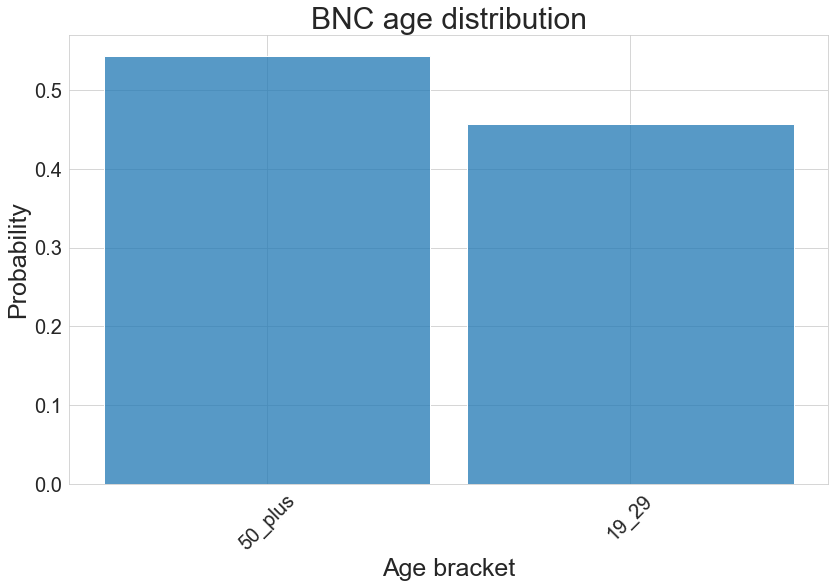

In [18]:
# Age distribution, unconditional
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
hist = sns.histplot(tcbi_df, x = "age_cat", stat = "probability", multiple='dodge', shrink=0.9)
# for legend title and fontsizes
# plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE) 
# plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE) 
# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=45, fontsize = TICK_SIZE)
plt.yticks(rotation = 0, fontsize = TICK_SIZE)
plt.title("BNC age distribution", fontsize = TITLE_SIZE)
plt.xlabel("Age bracket", fontsize = LABEL_SIZE)
plt.ylabel("Probability", fontsize = LABEL_SIZE)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
# plt.savefig('../../figures/paper/bnc_rb_age_gender_dist.png')

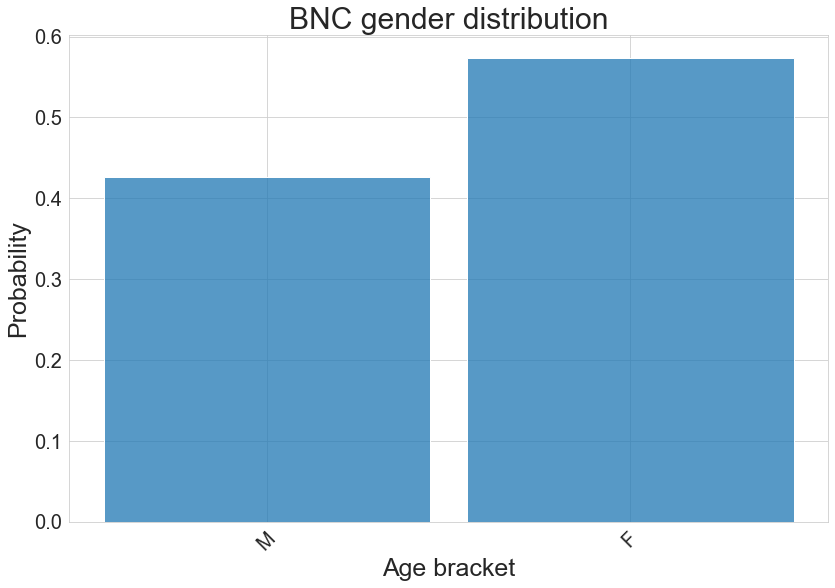

In [19]:
# Age distribution, unconditional
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
hist = sns.histplot(tcbi_df, x = "gender", stat = "probability", multiple='dodge', shrink=0.9)
# for legend title and fontsizes
# plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE) 
# plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE) 
# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=45, fontsize = TICK_SIZE)
plt.yticks(rotation = 0, fontsize = TICK_SIZE)
plt.title("BNC gender distribution", fontsize = TITLE_SIZE)
plt.xlabel("Age bracket", fontsize = LABEL_SIZE)
plt.ylabel("Probability", fontsize = LABEL_SIZE)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
# plt.savefig('../../figures/paper/bnc_rb_age_gender_dist.png')

# When BERT was right and Trigram wasn't

In [20]:
tibc_df = case_df[(case_df.trigram_pred != case_df.label) & (case_df.bert_pred == case_df.label)]

In [21]:

# lil switcheroo to make '19-29' appear first in the plot
b, c = tibc_df.loc[4, :].copy(), tibc_df.loc[5, :].copy()
tibc_df.loc[5, :],tibc_df.loc[4, :] = c,b

KeyError: 4

In [22]:
tibc_df

,text_id,speaker_id,gender,topics,conv_id,turn,text,length,age_cat,clean_text,label,trigram_pred,bert_pred,clean_length
20,32276,S0680,F,"['orchids', 'birthday cakes', 'school dinners'...",SHHX,527,oh so you you were in mixed?,8,50_plus,oh so you you were in mixed?,1,0,1,7
37,40522,S0179,M,"['making arrangements', 'football', 'cars', 't...",SMMK,62,can't quite believe you didn't recognise that,9,19_29,can't quite believe you didn't recognise that,0,1,0,7
47,26699,S0680,F,"['making a shopping list', 'ages on birthday c...",SEVC,267,no I mean earlier earlier when he was at unive...,16,50_plus,no i mean earlier earlier when he was at unive...,1,0,1,16
60,63193,S0013,F,"['looking at pictures', 'dentists', 'gardening']",SYDJ,396,so why was it left there?,7,50_plus,so why was it left there?,1,0,1,6
71,17184,S0281,M,"['food', 'china', 'laptop']",S9ZP,349,very er only er a hundred pound each a month,10,50_plus,very er only er a hundred pound each a month,1,0,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6688,49244,S0281,M,"['scottish referendum', 'job interview', 'coll...",SQWW,267,I can't be an examiner,6,50_plus,i can't be an examiner,1,0,1,5
6701,29616,S0242,M,"['vegan food', 'eating meat', 'back pain', 'pu...",SG2E,241,"ah yeah <pause dur=""short"" /> oh <trunc>we</tr...",24,50_plus,"ah yeah <pause dur=""short"" /> oh <trunc>we</tr...",1,0,1,28
6714,3516,S0198,F,"['smoking cigarettes', 'moving apartments', 'f...",S38V,2710,those two have been sitting there as well <pau...,8,19_29,those two have been sitting there as well <pau...,0,1,0,11
6719,45960,S0524,M,"['career details as a producer for the bbc', '...",SPY2,368,it <trunc>ju</trunc> that's just an eroded roc...,11,50_plus,it <trunc>ju</trunc> that's just an eroded roc...,1,0,1,9


In [23]:
tibc_df.reset_index(drop=True, inplace=True)

In [24]:
tibc_df.clean_length.describe()

count    615.000000
mean      11.534959
std       12.115957
min        1.000000
25%        4.000000
50%        8.000000
75%       15.000000
max      138.000000
Name: clean_length, dtype: float64

## Descriptive stats for case2: trigram incorrec and BERT correct

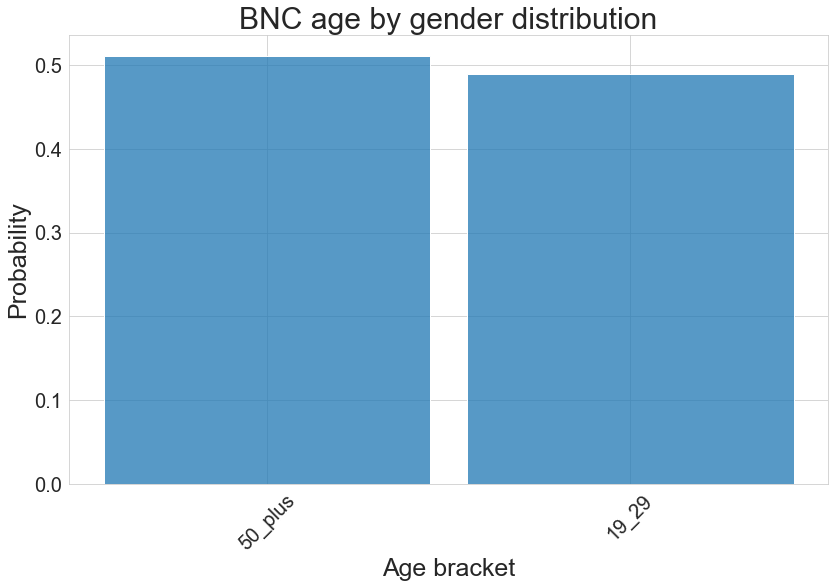

In [25]:
# Age distribution, unconditional
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
hist = sns.histplot(tibc_df, x = "age_cat", stat = "probability", multiple='dodge', shrink=0.9)
# for legend title and fontsizes
# plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE) 
# plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE) 
# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=45, fontsize = TICK_SIZE)
plt.yticks(rotation = 0, fontsize = TICK_SIZE)
plt.title("BNC age by gender distribution", fontsize = TITLE_SIZE)
plt.xlabel("Age bracket", fontsize = LABEL_SIZE)
plt.ylabel("Probability", fontsize = LABEL_SIZE)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
# plt.savefig('../../figures/paper/bnc_rb_age_gender_dist.png')

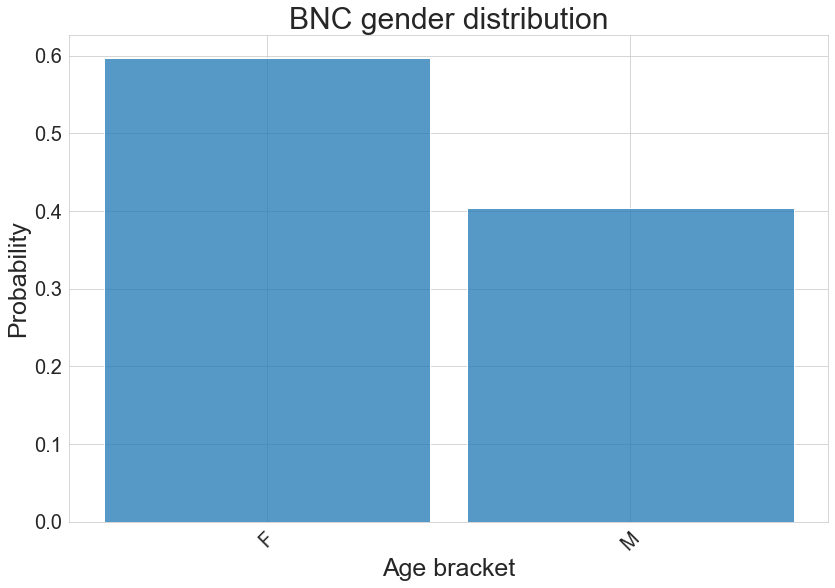

In [26]:
# Age distribution, unconditional
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
hist = sns.histplot(tibc_df, x = "gender", stat = "probability", multiple='dodge', shrink=0.9)
# for legend title and fontsizes
# plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE) 
# plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE) 
# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=45, fontsize = TICK_SIZE)
plt.yticks(rotation = 0, fontsize = TICK_SIZE)
plt.title("BNC gender distribution", fontsize = TITLE_SIZE)
plt.xlabel("Age bracket", fontsize = LABEL_SIZE)
plt.ylabel("Probability", fontsize = LABEL_SIZE)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
# plt.savefig('../../figures/paper/bnc_rb_age_gender_dist.png')

# When they were both wrong

In [27]:
tibi_df = case_df[(case_df.trigram_pred != case_df.label) & (case_df.bert_pred != case_df.label)]

In [28]:
tibi_df

,text_id,speaker_id,gender,topics,conv_id,turn,text,length,age_cat,clean_text,label,trigram_pred,bert_pred,clean_length
1,8799,S0281,M,"['business idea', 'friends', 'international ne...",S6AP,107,but she did the same thing she she <pause dur=...,24,50_plus,but she did the same thing she she <pause dur=...,1,0,0,27
6,18810,S0486,F,['childhood memories of the war years.'],SBS5,3,"<vocal desc=""laugh"" />",0,50_plus,"<vocal desc=""laugh"" />",1,0,0,3
8,4219,S0248,M,['superstitions / good luck / bad luck / sport...,S3TD,104,<unclear>sound the</unclear> <trunc>f</trunc> ...,21,50_plus,<unclear>sound the</unclear> <trunc>f</trunc> ...,1,0,0,26
9,20591,S0179,M,"['food', 'holidays']",SD6X,1814,mm,1,19_29,mm,0,1,1,1
11,44279,S0012,M,['no info'],SP5U,477,what is the point?,5,50_plus,what is the point?,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6698,64886,S0679,F,['planning the day visits to open farm sunday'...,SZBN,46,"yeah <pause dur=""short"" /> erm <pause dur=""sho...",38,50_plus,"yeah <pause dur=""short"" /> erm <pause dur=""sho...",1,0,0,51
6700,42688,S0282,F,['advice about renovation projects for histori...,SNXL,95,oh <unclear />,2,50_plus,oh <unclear />,1,0,0,3
6703,25795,S0557,F,"['future plans', 'relationships', 'trip to edi...",SEM7,489,mm,1,19_29,mm,0,1,1,1
6710,48317,S0536,M,['successful career inventing and marketing pr...,SQ63,170,"<vocal desc=""laugh"" />",0,50_plus,"<vocal desc=""laugh"" />",1,0,0,3


In [29]:
tibi_df.clean_length.describe()

count    1331.000000
mean        5.815177
std         8.328073
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max        99.000000
Name: clean_length, dtype: float64

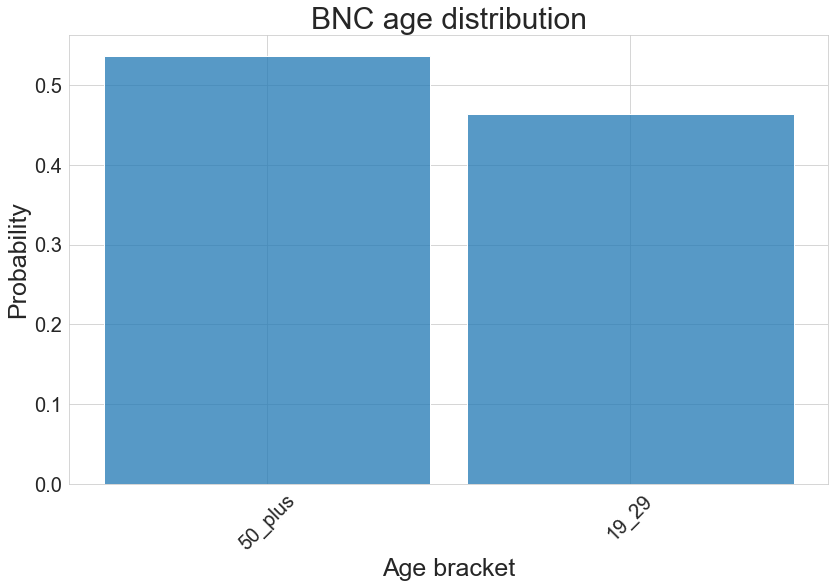

In [30]:
# Age distribution, unconditional
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
hist = sns.histplot(tibi_df, x = "age_cat", stat = "probability", multiple='dodge', shrink=0.9)
# for legend title and fontsizes
# plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE) 
# plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE) 
# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=45, fontsize = TICK_SIZE)
plt.yticks(rotation = 0, fontsize = TICK_SIZE)
plt.title("BNC age distribution", fontsize = TITLE_SIZE)
plt.xlabel("Age bracket", fontsize = LABEL_SIZE)
plt.ylabel("Probability", fontsize = LABEL_SIZE)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
# plt.savefig('../../figures/paper/bnc_rb_age_gender_dist.png')

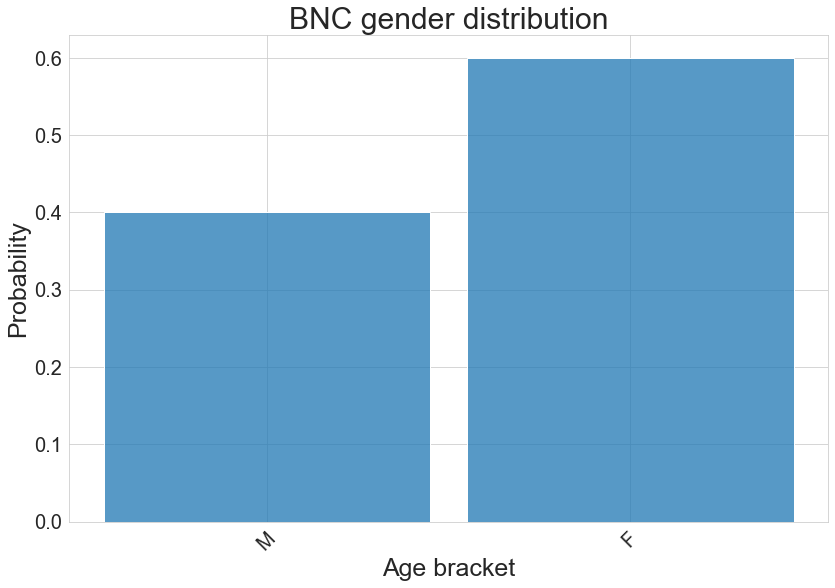

In [31]:
# Age distribution, unconditional
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
hist = sns.histplot(tibi_df, x = "gender", stat = "probability", multiple='dodge', shrink=0.9)
# for legend title and fontsizes
# plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE) 
# plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE) 
# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=45, fontsize = TICK_SIZE)
plt.yticks(rotation = 0, fontsize = TICK_SIZE)
plt.title("BNC gender distribution", fontsize = TITLE_SIZE)
plt.xlabel("Age bracket", fontsize = LABEL_SIZE)
plt.ylabel("Probability", fontsize = LABEL_SIZE)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
# plt.savefig('../../figures/paper/bnc_rb_age_gender_dist.png')

# When they were both right

In [32]:
tcbc_df = case_df[(case_df.trigram_pred == case_df.label) & (case_df.bert_pred == case_df.label)]

In [33]:
tcbc_df

,text_id,speaker_id,gender,topics,conv_id,turn,text,length,age_cat,clean_text,label,trigram_pred,bert_pred,clean_length
2,54809,S0041,F,[],SU82,2045,has considered me dead,4,19_29,has considered me dead,0,0,0,4
3,1431,S0238,F,"['hand-thrown mugs', 'milk', 'weather', 'spide...",S2UT,239,if they're doing all that er,7,50_plus,if they're doing all that er,1,1,1,6
4,33122,S0265,M,['travel and domestic arrangements'],SJAW,46,oh right,2,50_plus,oh right,1,1,1,2
5,16942,S0281,M,"['food', 'china', 'laptop']",S9ZP,107,yeah well there you go,5,50_plus,yeah well there you go,1,1,1,5
7,26783,S0680,F,"['making a shopping list', 'ages on birthday c...",SEVC,351,yes,1,50_plus,yes,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6722,56718,S0670,M,"['shakespeare', 'sarcasm', 'skill learning and...",SVCT,69,is that One Life?,5,19_29,is that one life?,0,0,0,4
6723,66455,S0450,F,"['food', 'holidays', 'memories', 'catching-up'...",SZQX,2294,until,1,19_29,until,0,0,0,1
6724,53459,S0451,F,"['gym', 'holidays', 'nights out', 'food', 'fri...",STKV,882,yeah I know I can imagine like a big erm,10,19_29,yeah i know i can imagine like a big erm,0,0,0,10
6725,10742,S0530,F,"['the future and old age', 'art', 'essays', 'c...",S7NV,605,<unclear>do</unclear>,0,19_29,<unclear>do</unclear>,0,0,0,1


In [34]:
tcbc_df.clean_length.describe()

count    4251.000000
mean       13.507880
std        18.977724
min         1.000000
25%         2.000000
50%         7.000000
75%        17.000000
max       195.000000
Name: clean_length, dtype: float64

In [35]:
len(tcbc_df[tcbc_df['age_cat'] == '50_plus']) / len(tcbc_df)

0.48153375676311455

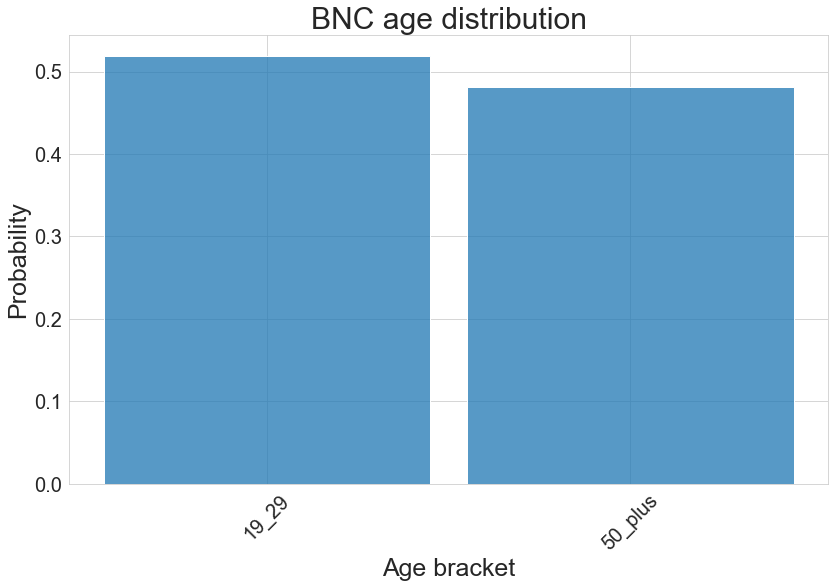

In [36]:
# Age distribution, unconditional
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
hist = sns.histplot(tcbc_df, x = "age_cat", stat = "probability", multiple='dodge', shrink=0.9)
# for legend title and fontsizes
# plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE) 
# plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE) 
# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=45, fontsize = TICK_SIZE)
plt.yticks(rotation = 0, fontsize = TICK_SIZE)
plt.title("BNC age distribution", fontsize = TITLE_SIZE)
plt.xlabel("Age bracket", fontsize = LABEL_SIZE)
plt.ylabel("Probability", fontsize = LABEL_SIZE)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
# plt.savefig('../../figures/paper/bnc_rb_age_gender_dist.png')

## Lets try everything in one dataframe

In [37]:
# np.where(condition, value if condition is true, value if condition is false)
case_df['trigram_correct'] = np.where(case_df['label'] == case_df['trigram_pred'], True, False)

In [38]:
case_df.head()

,text_id,speaker_id,gender,topics,conv_id,turn,text,length,age_cat,clean_text,label,trigram_pred,bert_pred,clean_length,trigram_correct
0,37437,S0681,M,"['discussing the past day', 'wicken fen nature...",SLJ5,527,no I haven't,4,50_plus,no i haven't,1,1,0,3,True
1,8799,S0281,M,"['business idea', 'friends', 'international ne...",S6AP,107,but she did the same thing she she <pause dur=...,24,50_plus,but she did the same thing she she <pause dur=...,1,0,0,27,False
2,54809,S0041,F,[],SU82,2045,has considered me dead,4,19_29,has considered me dead,0,0,0,4,True
3,1431,S0238,F,"['hand-thrown mugs', 'milk', 'weather', 'spide...",S2UT,239,if they're doing all that er,7,50_plus,if they're doing all that er,1,1,1,6,True
4,33122,S0265,M,['travel and domestic arrangements'],SJAW,46,oh right,2,50_plus,oh right,1,1,1,2,True


In [39]:
sum(case_df.trigram_correct)/len(case_df)

0.710803982761183

In [40]:
case_df['bert_correct'] = np.where(case_df['label'] == case_df['bert_pred'], True, False)

In [41]:
# Table of error case percentages
print(f'Trigram correct - BERT incorrect: {(len(tcbi_df) / len(case_df)) * 100} %')
print(f'Trigram incorrect - BERT correct: {(len(tibc_df) / len(case_df)) * 100} %')
print(f'Trigram incorrect - BERT incorrect: {(len(tibi_df) / len(case_df)) * 100} %')
print(f'Trigram correct - BERT correct: {(len(tcbc_df) / len(case_df)) * 100} %')

Trigram correct - BERT incorrect: 7.906078169118739 %
Trigram incorrect - BERT correct: 9.139545251894782 %
Trigram incorrect - BERT incorrect: 19.780056471986924 %
Trigram correct - BERT correct: 63.17432010699956 %


In [43]:
7.91 + 9.14 + 19.78 + 63.17

100.0

In [44]:
def case_col(row):
    
    if row['trigram_correct'] and row['bert_correct']:
        val = 'both_right'
    elif not row['trigram_correct'] and not row['bert_correct']:
        val = 'both_wrong'
    elif not row['trigram_correct'] and row['bert_correct']:
        val = 'bert_right'
    elif row['trigram_correct'] and not row['bert_correct']:
        val= '3gram_right'
    return val

In [45]:
case_df['case'] = case_df.apply(case_col, axis=1)

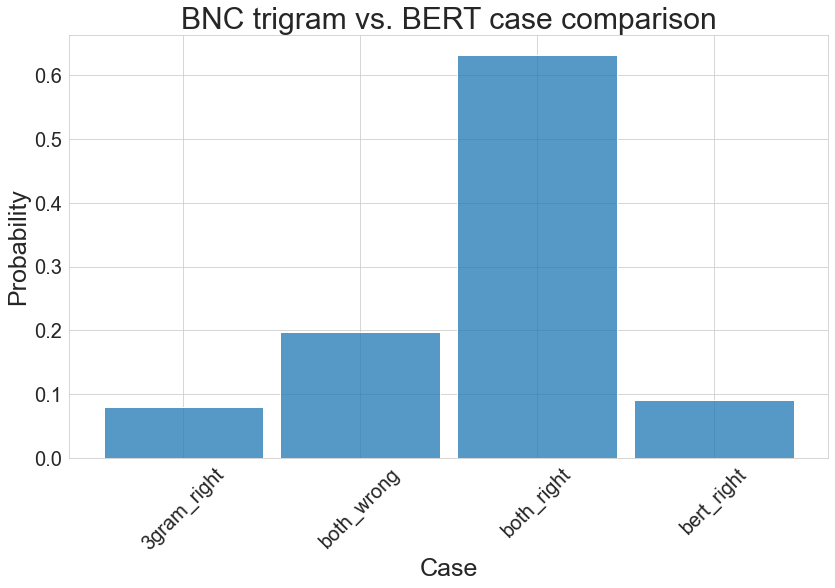

In [46]:
# Case distribution, unconditional
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
hist = sns.histplot(case_df, x = "case", stat = "probability",  multiple='stack', shrink=0.9)
# for legend title and fontsizes
# plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE) 
# plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE) 
# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=45, fontsize = TICK_SIZE)
plt.yticks(rotation = 0, fontsize = TICK_SIZE)
plt.title("BNC trigram vs. BERT case comparison", fontsize = TITLE_SIZE)
plt.xlabel("Case", fontsize = LABEL_SIZE)
plt.ylabel("Probability", fontsize = LABEL_SIZE)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
# plt.savefig('../figures/paper/bnc_rb_trigram_bert_case_dist.png')

In [47]:
# lil switcheroo to make '19-29' appear first in the plot
b, c = case_df.loc[0, :].copy(), case_df.loc[2, :].copy()
case_df.loc[0, :],case_df.loc[2, :] = c,b

In [48]:
case_df

,text_id,speaker_id,gender,topics,conv_id,turn,text,length,age_cat,clean_text,label,trigram_pred,bert_pred,clean_length,trigram_correct,bert_correct,case
0,54809,S0041,F,[],SU82,2045,has considered me dead,4,19_29,has considered me dead,0,0,0,4,True,True,both_right
1,8799,S0281,M,"['business idea', 'friends', 'international ne...",S6AP,107,but she did the same thing she she <pause dur=...,24,50_plus,but she did the same thing she she <pause dur=...,1,0,0,27,False,False,both_wrong
2,37437,S0681,M,"['discussing the past day', 'wicken fen nature...",SLJ5,527,no I haven't,4,50_plus,no i haven't,1,1,0,3,True,False,3gram_right
3,1431,S0238,F,"['hand-thrown mugs', 'milk', 'weather', 'spide...",S2UT,239,if they're doing all that er,7,50_plus,if they're doing all that er,1,1,1,6,True,True,both_right
4,33122,S0265,M,['travel and domestic arrangements'],SJAW,46,oh right,2,50_plus,oh right,1,1,1,2,True,True,both_right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6724,53459,S0451,F,"['gym', 'holidays', 'nights out', 'food', 'fri...",STKV,882,yeah I know I can imagine like a big erm,10,19_29,yeah i know i can imagine like a big erm,0,0,0,10,True,True,both_right
6725,10742,S0530,F,"['the future and old age', 'art', 'essays', 'c...",S7NV,605,<unclear>do</unclear>,0,19_29,<unclear>do</unclear>,0,0,0,1,True,True,both_right
6726,49689,S0671,M,['science general activities anecdotes tv li...,SR9W,374,yes,1,19_29,yes,0,1,1,1,False,False,both_wrong
6727,58564,S0426,M,"['home decorating', 'bathrooms', 'tradespeople...",SWW8,12,bloody hell,2,50_plus,bloody hell,1,0,1,2,False,True,bert_right


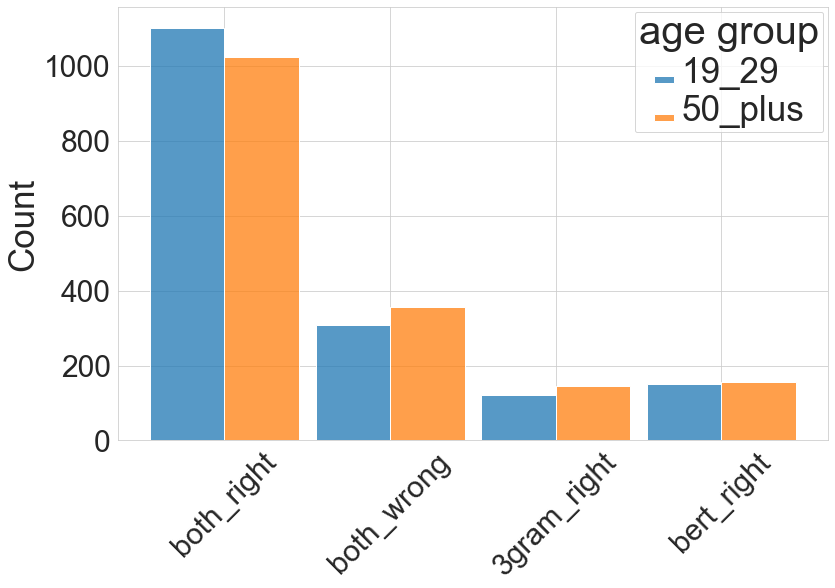

In [49]:
# Case distribution, by age group
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
case_df.rename(columns={'age_cat': 'age group'}, inplace=True)
hist = sns.histplot(case_df, x = "case", stat = "frequency", hue='age group',  multiple='dodge', shrink=0.9)
case_df.rename(columns={'age group': 'age_cat'}, inplace=True)
# for legend title and fontsizes
plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE + 15) 
plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE + 15) 
# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=45, fontsize = TICK_SIZE + 10)
plt.yticks(rotation = 0, fontsize = TICK_SIZE + 10)
plt.title("", fontsize = TITLE_SIZE)
plt.xlabel("", fontsize = LABEL_SIZE)
plt.ylabel("Count", fontsize = LABEL_SIZE + 10)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
plt.savefig('../figures/paper/bnc_rb_trigram_bert_case_dist_hue_age_ws.png')

In [44]:
len(case_df)

6729

In [ ]:
# Misclassification rates by age per model

In [57]:
len(case_df[(case_df['age_cat'] == '50_plus') & (case_df['trigram_correct'] == False)])

1028

In [58]:
len(case_df[(case_df['age_cat'] == '19_29') & (case_df['trigram_correct'] == False)])

918

In [59]:
1028/918

1.1198257080610021

# Time for some (pseudo-)random samples

### Both right

In [69]:
# Both right
tcbc_sample = tcbc_df.sample(n=50, random_state=2021)
tcbc_sample.reset_index(drop=True, inplace=True)
tcbc_sample = tcbc_sample[['age_cat', 'gender', 'text']]

tcbc_sample

In [71]:
tcbc_sample.to_csv('ca_samples/both_right_ws.csv', index=False)

### Both wrong

In [72]:
# Both wrong
tibi_sample = tibi_df.sample(n=50, random_state=2021)
tibi_sample.reset_index(drop=True, inplace=True)
tibi_sample = tibi_sample[['age_cat', 'gender', 'text']]

In [73]:
# tibi_sample

In [74]:
tibi_sample.to_csv('ca_samples/both_wrong_ws.csv', index=False)

### BERT right (trigram wrong)

In [75]:
# BERT right
tibc_sample = tibc_df.sample(n=50, random_state=2021)
tibc_sample.reset_index(drop=True, inplace=True)
tibc_sample = tibc_sample[['age_cat', 'gender', 'text']]

In [76]:
# tibc_sample

In [77]:
tibc_sample.to_csv('ca_samples/bert_right_ws.csv', index=False)

### Trigram right (BERT wrong)

In [78]:
# Trigram right
tcbi_sample = tcbi_df.sample(n=50, random_state=2021)
tcbi_sample.reset_index(drop=True, inplace=True)
tcbi_sample = tcbi_sample[['age_cat', 'gender', 'text']]

In [79]:
# tcbi_sample

In [80]:
tcbi_sample.to_csv('ca_samples/3gram_right_ws.csv', index=False)

In [59]:
# tcbi_sample

# Performance metrics per topic

In [60]:
case_df

,text_id,speaker_id,gender,topics,conv_id,turn,text,length,age_cat,clean_text,label,trigram_pred,bert_pred,clean_length,trigram_correct,bert_correct,case
0,37437,S0681,M,"['discussing the past day', 'wicken fen nature...",SLJ5,527,no I haven't,4,50_plus,no i haven't,1,1,0,3,True,False,3gram_right
1,8799,S0281,M,"['business idea', 'friends', 'international ne...",S6AP,107,but she did the same thing she she <pause dur=...,24,50_plus,but she did the same thing she she <pause dur=...,1,0,0,27,False,False,both_wrong
2,54809,S0041,F,[],SU82,2045,has considered me dead,4,19_29,has considered me dead,0,0,0,4,True,True,both_right
3,1431,S0238,F,"['hand-thrown mugs', 'milk', 'weather', 'spide...",S2UT,239,if they're doing all that er,7,50_plus,if they're doing all that er,1,1,1,6,True,True,both_right
4,33122,S0265,M,['travel and domestic arrangements'],SJAW,46,oh right,2,50_plus,oh right,1,1,1,2,True,True,both_right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6724,53459,S0451,F,"['gym', 'holidays', 'nights out', 'food', 'fri...",STKV,882,yeah I know I can imagine like a big erm,10,19_29,yeah i know i can imagine like a big erm,0,0,0,10,True,True,both_right
6725,10742,S0530,F,"['the future and old age', 'art', 'essays', 'c...",S7NV,605,<unclear>do</unclear>,0,19_29,<unclear>do</unclear>,0,0,0,1,True,True,both_right
6726,49689,S0671,M,['science general activities anecdotes tv li...,SR9W,374,yes,1,19_29,yes,0,1,1,1,False,False,both_wrong
6727,58564,S0426,M,"['home decorating', 'bathrooms', 'tradespeople...",SWW8,12,bloody hell,2,50_plus,bloody hell,1,0,1,2,False,True,bert_right


In [ ]:
topics_set = set()
all_topics_list = []
topics_counter = Counter
for topic_list in case_df.topics:
    topic_list = ast.literal_eval(topic_list)
    topic_list = [re.sub(r'[^A-Za-z]+',' ', topic).strip() for topic in topic_list]
    topics_set.update(topic_list)
    all_topics_list = all_topics_list + topic_list

In [ ]:
len(topics_set)

In [ ]:
# Topic counter
topic_counter = Counter(all_topics_list)

In [ ]:
topic_counter.most_common(30)

In [ ]:
top_10_topics_counts =[('food', 10638),
 ('work', 10425),
 ('friends', 9010),
 ('family', 6342),
 ('relationships', 5033),
 ('future plans', 4974),
 ('no info', 4181),
 ('holidays', 4123),
 ('university', 2999),
 ('cooking', 2612),
 ('travelling', 2051),
 ('health', 1814),
 ('ex boyfriends', 1662),
 ('tv', 3037),
 ('catch up', 1567),
 ('marriage', 1545),
 ('shopping', 1513),
 ('weather', 1472)]


# top_10_topics_counts = [('food', 10638),
#  ('work', 10425),
#  ('friends', 9010),
#  ('family', 6342),
#  ('relationships', 5033),
#  ('future plans', 4974),
#  ('no info', 4181),
#  ('holidays', 4123),
#  ('university', 2999),
#  ('cooking', 2612),
#  ('travelling', 2051),
#  ('health', 1814),
#  ('ex boyfriends', 1662),
#  ('tv', 1569),
#  ('catch up', 1567),
#  ('marriage', 1545),
#  ('shopping', 1513),
#  ('weather', 1472),
#  ('tv shows', 1468),
#  ('scottish referendum', 1423),
#  ('cars', 1406),
#  ('films', 1385),
#  ('job interview', 1310),
#  ('colleague', 1310)]

In [ ]:
1569+1468

In [ ]:
top_10_topics_list = [topic for topic, freq in top_10_topics_counts]

In [ ]:
top_10_topics_list

In [ ]:
def freq_topic_col(topic_list, top_topic_list=top_10_topics_list):
    
    topic_list = ast.literal_eval(topic_list)
    topic_list = [re.sub(r'[^A-Za-z]+',' ', topic).strip() for topic in topic_list]
    overlap = [topic for topic in topic_list if topic in top_topic_list]
    
    if overlap == []:
        overlap = 'none'
        return overlap
    else:
        return overlap[0]

case_df['freq_topics'] = case_df['topics'].apply(freq_topic_col)

In [ ]:
case_df_temp = case_df[(case_df['freq_topics'] != 'none') & (case_df['freq_topics'] != 'no info')]

In [ ]:
# case_df_temp = case_df

In [ ]:
# Case distribution, by age group
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
hist = sns.histplot(case_df_temp, x = "freq_topics", stat = "probability", hue='bert_correct',  multiple='dodge', shrink=0.9)
# for legend title and fontsizes
plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE) 
plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE) 
# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=70, fontsize = TICK_SIZE)
plt.yticks(rotation = 0, fontsize = TICK_SIZE)
plt.title("BNC trigram vs. BERT case comparison, split by age.", fontsize = TITLE_SIZE)
plt.xlabel("Case", fontsize = LABEL_SIZE)
plt.ylabel("Probability", fontsize = LABEL_SIZE)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
# plt.savefig('../figures/paper/bnc_rb_trigram_bert_case_dist_hue_age.png')

In [ ]:
keys = ['topic', 'bert_acc', 'trigram_acc', 
        'bert_f1_young', 'bert_f1_old']#, 
#         'tg_f1_young', 'tg_f1_old']
topic_perf_df = pd.DataFrame(columns=keys)

In [ ]:
for topic in case_df_temp.freq_topics.unique():
    bert_acc = len(case_df_temp[(case_df_temp.freq_topics == topic) & (case_df_temp.bert_correct == True)]) / len(case_df_temp[case_df_temp.freq_topics == topic])
    trigram_acc = len(case_df_temp[(case_df_temp.freq_topics == topic) & (case_df_temp.trigram_correct == True)]) / len(case_df_temp[case_df_temp.freq_topics == topic])
    
    # f1 calculations
    ### BERT 
    bert_tp_young = len(case_df_temp[(case_df_temp.freq_topics == topic) & (case_df_temp.bert_pred == 0) & (case_df_temp.label == 0)])
    bert_fp_young = len(case_df_temp[(case_df_temp.freq_topics == topic) & (case_df_temp.bert_pred == 0) & (case_df_temp.label == 1)])
    bert_fn_young = len(case_df_temp[(case_df_temp.freq_topics == topic) & (case_df_temp.bert_pred == 1) & (case_df_temp.label == 0)])
    
    bert_tp_old = len(case_df_temp[(case_df_temp.freq_topics == topic) & (case_df_temp.bert_pred == 1) & (case_df_temp.label == 1)])
    bert_fp_old = len(case_df_temp[(case_df_temp.freq_topics == topic) & (case_df_temp.bert_pred == 1) & (case_df_temp.label == 0)])
    bert_fn_old = len(case_df_temp[(case_df_temp.freq_topics == topic) & (case_df_temp.bert_pred == 0) & (case_df_temp.label == 1)])
    
    f1_y_valid = True
    f1_o_valid = True
    
    bert_pr_young = bert_tp_young / (bert_tp_young + bert_fp_young)
    try:
        bert_rc_young = bert_tp_young / (bert_tp_young + bert_fn_young)
    except ZeroDivisionError:
        #from pdb import set_trace
        #set_trace()
        bert_rc_young = 0
        f1_y_valid = False
        print(topic)
    
    bert_pr_old = bert_tp_old / (bert_tp_old + bert_fp_old)
    #bert_rc_old = bert_tp_old / (bert_tp_old + bert_fn_old)
    try:
        bert_rc_old = bert_tp_old / (bert_tp_old + bert_fn_old)
    except ZeroDivisionError:
        #from pdb import set_trace
        #set_trace()
        bert_rc_old = 0
        f1_o_valid = False
        print(topic)
        
    if f1_y_valid:
        bert_f1_young = 2 * (bert_pr_young * bert_rc_young) / (bert_pr_young + bert_rc_young)
    else:
        bert_f1_young = 'N/A'
        
    if f1_o_valid:
        bert_f1_old = 2 * (bert_pr_old * bert_rc_old) / (bert_pr_old + bert_rc_old)
    else:
        bert_f1_old = 'N/A'
    
#     try:
#         bert_f1_young = 2 * (bert_pr_young * bert_rc_young) / (bert_pr_young + bert_rc_young)
#     except ZeroDivisionError:
#         bert_f1_young = 0
    
#     #bert_f1_old = 2 * (bert_pr_old * bert_rc_old) / (bert_pr_old + bert_rc_old)
#     try:
#         bert_f1_old = 2 * (bert_pr_old * bert_rc_old) / (bert_pr_old + bert_rc_old)
#     except ZeroDivisionError:
#         bert_f1_old = 0

#     if topic == 'health':
#         pdb.set_trace()
    
    
    topic_perf_df.loc[0 if pd.isnull(topic_perf_df.index.max()) else topic_perf_df.index.max() + 1] = [topic] + [bert_acc] + [trigram_acc] + [bert_f1_young] + [bert_f1_old]

In [ ]:
len(case_df_temp[(case_df_temp.freq_topics == 'health') & (case_df_temp.bert_correct == True) & (case_df_temp.label == 1)])

In [ ]:
topic_perf_df[['topic', 'bert_acc', 'bert_f1_young', 'bert_f1_old']]

In [ ]:
# Case distribution, by age group
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
hist = sns.barplot(data=topic_perf_df, x = "topic", y='bert_acc', palette='mako')
# for legend title and fontsizes
# plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE) 
# plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE) 
# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=70, fontsize = TICK_SIZE)
plt.yticks(rotation = 0, fontsize = TICK_SIZE)
plt.title("BNC BERT test accuracy for most frequent topics", fontsize = TITLE_SIZE)
plt.xlabel("Topic", fontsize = LABEL_SIZE)
plt.ylabel("Test accuracy", fontsize = LABEL_SIZE)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
# plt.savefig('../figures/paper/bnc_rb_bert_acc_freq_topics.png')

In [ ]:
# Case distribution, by age group
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
hist = sns.barplot(data=topic_perf_df, x = "topic", y='trigram_acc', palette='mako')
# for legend title and fontsizes
# plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE) 
# plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE) 
# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=70, fontsize = TICK_SIZE)
plt.yticks(rotation = 0, fontsize = TICK_SIZE)
plt.title("BNC Trigram test accuracy for most frequent topics", fontsize = TITLE_SIZE)
plt.xlabel("Topic", fontsize = LABEL_SIZE)
plt.ylabel("Test accuracy", fontsize = LABEL_SIZE)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
# plt.savefig('../figures/paper/bnc_rb_trigram_acc_freq_topics.png')

In [ ]:
topic_perf_df

In [ ]:

plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
topic_perf_df.rename(columns={'bert_acc': 'bert', 'trigram_acc' : '3gram'}, inplace=True)
hist= topic_perf_df.plot(x="topic", y=["bert", "3gram"], kind="bar",figsize=PLOT_DIMS, width=0.6)
topic_perf_df.rename(columns={'bert': 'bert_acc', '3gram' : 'trigram_acc'}, inplace=True)
# hist = sns.barplot(data=topic_perf_df, x = "topic", y=["bert_acc", "trigram_acc"], palette='mako')
# for legend title and fontsizes
plt.legend(bbox_to_anchor = (0.3, 1.), ncol=2, fancybox=True, shadow=True)
plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE + 15) 
plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE + 15) 

# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=70, fontsize = TICK_SIZE + 5)
plt.yticks(rotation = 0, fontsize = TICK_SIZE + 10)
# plt.title("BNC BERT vs. Trigram accuracy frequent topics", fontsize = TITLE_SIZE)
plt.xlabel("", fontsize = LABEL_SIZE)
plt.ylabel("Test accuracy", fontsize = LABEL_SIZE + 10)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
plt.savefig('../figures/paper/bnc_rb_bert_trigram_acc_freq_topics.png')

### Now with none and no info

In [ ]:
keys = ['topic', 'bert_acc', 'trigram_acc']
topic_perf_none_df = pd.DataFrame(columns=keys)

for topic in case_df.freq_topics.unique():
    bert_acc = len(case_df[(case_df.freq_topics == topic) & (case_df.bert_correct == True)]) / len(case_df[case_df.freq_topics == topic])
    trigram_acc = len(case_df[(case_df.freq_topics == topic) & (case_df.trigram_correct == True)]) / len(case_df[case_df.freq_topics == topic])
    topic_perf_none_df.loc[0 if pd.isnull(topic_perf_none_df.index.max()) else topic_perf_none_df.index.max() + 1] = [topic] + [bert_acc] + [trigram_acc]

In [ ]:
topic_perf_none_df

In [ ]:
plt.figure(figsize=PLOT_DIMS)
sns.set_style("whitegrid")
topic_perf_none_df.rename(columns={'bert_acc': 'bert', 'trigram_acc' : '3gram'}, inplace=True)
hist= topic_perf_none_df.plot(x="topic", y=["bert", "3gram"], kind="bar",figsize=PLOT_DIMS, width=0.6)
topic_perf_none_df.rename(columns={'bert': 'bert_acc', '3gram' : 'trigram_acc'}, inplace=True)
# hist = sns.barplot(data=topic_perf_df, x = "topic", y=["bert_acc", "trigram_acc"], palette='mako')
# for legend title and fontsizes
plt.legend(bbox_to_anchor = (0.3, 1.), ncol=2, fancybox=True, shadow=True)
plt.setp(hist.get_legend().get_texts(), fontsize=TICK_SIZE + 15) 
plt.setp(hist.get_legend().get_title(), fontsize=LABEL_SIZE + 15) 

# plt.hist(df_pp['age_cat'])
# plt.legend()
plt.xticks(rotation=70, fontsize = TICK_SIZE + 5)
plt.yticks(rotation = 0, fontsize = TICK_SIZE + 10)
# plt.title("BNC BERT vs. Trigram accuracy frequent topics (incl. none/no info).", fontsize = TITLE_SIZE)
plt.xlabel("", fontsize = LABEL_SIZE)
plt.ylabel("Test accuracy", fontsize = LABEL_SIZE + 10)
# plt.legend(title='Team', fontsize='10', title_fontsize='14')
plt.tight_layout()
plt.savefig('../figures/paper/bnc_rb_bert_trigram_acc_freq_topics_w_none.png')

# F1 Plots for BERT and Trigram

In [ ]:
topic_perf_df[(~topic_perf_df.bert_f1_young.str.contains("N/A", na=False)) & (~topic_perf_df.bert_f1_old.str.contains("N/A", na=False))][['topic', 'bert_f1_young', 'bert_f1_old']]

In [ ]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))
